In [5]:
"""
Analyze NN predictions. This is hacky code to get predictions to Claudio fast. 
Peter July 12 2023

"""

import os
from collections import defaultdict
import numpy as np
import h5py
import matplotlib.pyplot as plt

import keras_core as keras

import tensorflow_io as tfio
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE

import preprocess

%load_ext autoreload
%autoreload 2

def get_trainset_feature(imodel, polarity='pos'):
    # This is a hack because I didn't keep track of 
    path = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/2023_07_01/'
    f = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed_training.h5'

    with h5py.File(f, 'r') as h5:
        #print([k for k in h5])
        num_samples, num_inputs,  = h5['X_minmax'].shape
        _, num_flux,  = h5['Y_log_scaled'].shape
        training_imodels = h5['imodel'][:]
    threshold = int(np.floor(num_samples *.9))   # Cutoff for training data. Depends on how it was trained.
    training_imodels = set(training_imodels[:threshold])  # Set of imodel events that are in training set.
    trainset = np.array([(i in training_imodels) for i in imodel])  # array
    return trainset

def write_predictions(model_path, infile, outfile, polarity):

    model = keras.models.load_model(model_path)

    # Load and process.
    X,Y,metadata = preprocess.preprocess_for_training(filename=infile, select_quality=False, shuffle_flag=False)

    # Transform data and write to new file.
    with h5py.File(outfile, 'w') as dest:
        # Write metadata vars as own dsets.
        for k,v in metadata.items():
            dset = dest.create_dataset(k, data=v)
        
        X_MIN = np.min(X, axis=0) #e.g. np.array([20., 4.5, 50., 0.2, 0.2, 0.2, 0.2])
        X_MAX = np.max(X, axis=0) #e.g. np.array([75., 8.5, 250., 2., 2.3, 2., 2.3])
        X_RANGE = X_MAX - X_MIN
        X_minmax = (X-X_MIN)/X_RANGE
    
    
        yhat = model.predict(X_minmax)  # Predict on transformed input.
        yhat = np.exp(yhat * preprocess.Y_LOG_MAX) # Inverse transform.
        dset = dest.create_dataset('flux_pred', data=yhat)

        # Add metadata to indicate whether example was in the trainset. 
        trainset = get_trainset_feature(metadata['imodel'], polarity=polarity)
        dset = dest.create_dataset('trainset', data=trainset)
    return yhat, Y, X_minmax, trainset, metadata

polarity = 'pos'
model_path = f'../models/model_v1.0_{polarity}.keras'  # Must end with keras.
path = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/2023_07_01/'
infile = f'{path}/pos/model_collection_1AU_90deg_0deg_fixed.h5'
outfile = f'predictions_{polarity}.h5'
yhat, Y, X_minmax, trainset, metadata = write_predictions(model_path, infile, outfile, polarity)

# polarity = 'neg'
# model_path = f'../models/model_v1.0_{polarity}.keras'  # Must end with keras.
# path = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/2023_07_01/'
# infile = f'{path}/pos/model_collection_1AU_90deg_0deg_fixed.h5'
# outfile = f'predictions_{polarity}.h5'
# yhat, Y, trainset, metadata = write_predictions(model_path, infile, outfile, polarity)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['info', 'model']
['LIS', 'rigidity']
['alpha', 'cmf', 'cpa', 'flux', 'imodel', 'ipar', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'quality', 'vseq', 'vspoles']
Found samples: 2851200
Num flux targets: 32
89100/89100 ━━━━━━━━━━━━━━━━━━━━ 52s 586us/step


In [4]:
model = keras.models.load_model(model_path)

# Load and process.
X,Y,metadata = preprocess.preprocess_for_training(filename=infile, select_quality=False, shuffle_flag=False)

# Transform data and write to new file.
with h5py.File(outfile, 'w') as dest:
    # Write metadata vars as own dsets.
    for k,v in metadata.items():
        dset = dest.create_dataset(k, data=v)
    
    X_MIN = np.min(X, axis=0) #e.g. np.array([20., 4.5, 50., 0.2, 0.2, 0.2, 0.2])
    X_MAX = np.max(X, axis=0) #e.g. np.array([75., 8.5, 250., 2., 2.3, 2., 2.3])
    X_RANGE = X_MAX - X_MIN
    X_minmax = (X-X_MIN)/X_RANGE

    yhat = model.predict(X_minmax)  # Predict on transformed input.
    yhat = np.exp(yhat * preprocess.Y_LOG_MAX) # Inverse transform.
    dset = dest.create_dataset('flux_pred', data=yhat)

    # Add metadata to indicate whether example was in the trainset. 
    trainset = get_trainset_feature(metadata['imodel'], polarity=polarity)
    dset = dest.create_dataset('trainset', data=trainset)

['info', 'model']
['LIS', 'rigidity']
['alpha', 'cmf', 'cpa', 'flux', 'imodel', 'ipar', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'quality', 'vseq', 'vspoles']
Found samples: 2851200
Num flux targets: 32
 2946/89100 ━━━━━━━━━━━━━━━━━━━━ 47s 547us/step

KeyboardInterrupt: 

In [6]:
# Quick check of predictions.
N = 1
print(yhat[:N, :])
print(Y[:N,:])
print(trainset[:N])
print(metadata['quality'][:N])
print(X_minmax[:N])


[[4.1657471e+02 4.2752875e+02 4.5025760e+02 4.8618570e+02 5.5168427e+02
  6.3885388e+02 7.5254034e+02 9.1840332e+02 1.1261331e+03 1.3771360e+03
  1.6882537e+03 2.0091813e+03 2.2924912e+03 2.4793757e+03 2.4829712e+03
  2.2766096e+03 1.8830265e+03 1.4129523e+03 9.6737445e+02 5.9729651e+02
  3.4779626e+02 1.7841309e+02 8.5851341e+01 3.6896553e+01 1.4395586e+01
  5.5203853e+00 1.9756215e+00 6.7982775e-01 2.1866201e-01 6.8109319e-02
  2.0639513e-02 6.5103360e-03]]
[[3.8808109e+02 3.9829218e+02 4.1938144e+02 4.5272223e+02 5.1300287e+02
  5.9342896e+02 6.9879449e+02 8.5268646e+02 1.0468781e+03 1.2843658e+03
  1.5848868e+03 1.9068853e+03 2.2077402e+03 2.4329204e+03 2.4825127e+03
  2.3152153e+03 1.9384889e+03 1.4609636e+03 9.9933624e+02 6.1454010e+02
  3.5673233e+02 1.8329799e+02 8.8913605e+01 3.8663464e+01 1.5219148e+01
  5.8448334e+00 2.0829129e+00 7.1326804e-01 2.2849810e-01 7.0868701e-02
  2.1356469e-02 6.5072728e-03]]
[ True]
[0]
[[0. 0. 0. 0. 0. 0. 0. 0.]]


(array([    0.,  2023., 31535., 34441., 20392.]),
 array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <BarContainer object of 5 artists>)

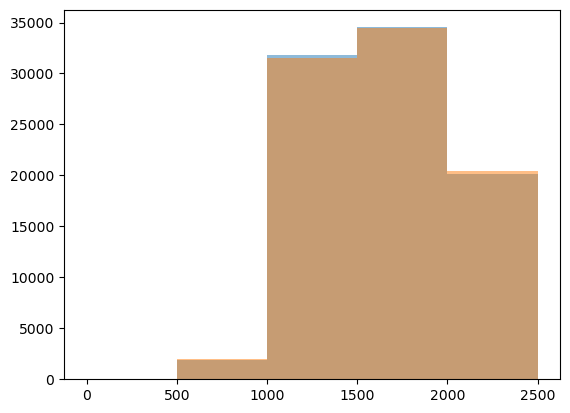

In [29]:
import matplotlib.pyplot as plt
N = 100000
i=16
bins = np.arange(0, 3000, 500)
plt.hist(yhat[:N, i], bins=bins, alpha=0.5,  label='pred')
plt.hist(Y[:N, i], bins=bins, alpha=0.5, label='true')

In [16]:
yhat.shape

(2851200, 32)

In [15]:
yhat[0, :N].shape

(32,)